#### A notebook for visualizing inputs and outputs for this project

In [1]:
import geopandas as gpd
import rasterio
import rioxarray as rio
import matplotlib.pyplot as plt
import folium
import contextily as ctx
import os

In [2]:
base_dir = "../../"
raw_dir = os.path.join(base_dir, 'data', 'raw')
processed_dir = os.path.join(base_dir, "data", "processed")
results_dir = os.path.join(base_dir, 'data', "results")

In [3]:
# --- Load Rasters ---
mndwi_2007 = rio.open_rasterio(os.path.join(processed_dir, "2007_mndwi.tif"), masked=True)
mndwi_2016 = rio.open_rasterio(os.path.join(processed_dir, "2016_mndwi.tif"), masked=True)
mndwi_2020 = rio.open_rasterio(os.path.join(processed_dir, "2020_mndwi.tif"), masked=True)
mndwi_2025 = rio.open_rasterio(os.path.join(processed_dir, "2025_mndwi.tif"), masked=True)
mask_2007 = rio.open_rasterio(os.path.join(processed_dir, "2007_mndwi_watermask.tif"), masked=True)
mask_2016 = rio.open_rasterio(os.path.join(processed_dir, "2016_mndwi_watermask.tif"), masked=True)
mask_2020 = rio.open_rasterio(os.path.join(processed_dir, "2020_mndwi_watermask.tif"), masked=True)
mask_2025 = rio.open_rasterio(os.path.join(processed_dir, "2025_mndwi_watermask.tif"), masked=True)
dem = rio.open_rasterio(os.path.join(raw_dir, "dem.tif"), masked=True)

# --- Load Vectors ---
vector_2007 = gpd.read_file(os.path.join(processed_dir, "2007_mndwi_watermask.shp"))
vector_2016 = gpd.read_file(os.path.join(processed_dir, "2016_mndwi_watermask.shp"))
vector_2020 = gpd.read_file(os.path.join(processed_dir, "2020_mndwi_watermask.shp"))
vector_2025 = gpd.read_file(os.path.join(processed_dir, "2025_mndwi_watermask.shp"))

dissolved_2007 = gpd.read_file(os.path.join(results_dir, "lake_2007.shp"))
dissolved_2016 = gpd.read_file(os.path.join(results_dir, "lake_2016.shp"))
dissolved_2020 = gpd.read_file(os.path.join(results_dir, "lake_2020.shp"))
dissolved_2025 = gpd.read_file(os.path.join(results_dir, "lake_2025.shp"))

growth_area = gpd.read_file(os.path.join(results_dir, 'growth_area.shp')).to_crs('EPSG:4326')
buildings = gpd.read_file(os.path.join(processed_dir, 'buildings.gpkg'))
roads = gpd.read_file(os.path.join(processed_dir, 'roads.gpkg'))
roads = roads[roads.geom_type.isin(['LineString', 'MultiLineString'])]
facilities = gpd.read_file(os.path.join(processed_dir, 'facilities.gpkg'))
facilities = facilities[facilities.geom_type.isin(['[Polygon]'])]


In [4]:
buildings = buildings.to_crs(growth_area.crs)
roads = roads.to_crs(growth_area.crs)
facilities = facilities.to_crs(growth_area.crs)
# Intersection — what lies within the expanded lake area
# submerged_buildings = gpd.overlay(buildings, growth_area, how="intersection")
# submerged_roads = gpd.overlay(roads, growth_area, how="intersection")
# submerged_facilities = gpd.overlay(facilities, growth_area, how="intersection")

In [5]:
dissolved_2007 = dissolved_2007.to_crs(growth_area.crs)
dissolved_2016 = dissolved_2016.to_crs(growth_area.crs)
dissolved_2025 = dissolved_2025.to_crs(growth_area.crs)
# submerged_buildings = submerged_buildings.to_crs(dissolved_2007.crs)
# submerged_roads = submerged_roads.to_crs(dissolved_2007.crs)
# submerged_facilities = submerged_facilities.to_crs(dissolved_2007.crs)

In [6]:
# --- CRS alignment check ---
print("Raster CRS:", dem.rio.crs)
print("Vector CRS:", vector_2016.crs)
if vector_2016.crs != mndwi_2016.rio.crs:
    vector_2016 = vector_2016.to_crs(mndwi_2016.rio.crs)


Raster CRS: EPSG:32636
Vector CRS: EPSG:32636


C:\Users\ADMIN\AppData\Local\Temp\ipykernel_884\1897584278.py:9: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  plt.legend()


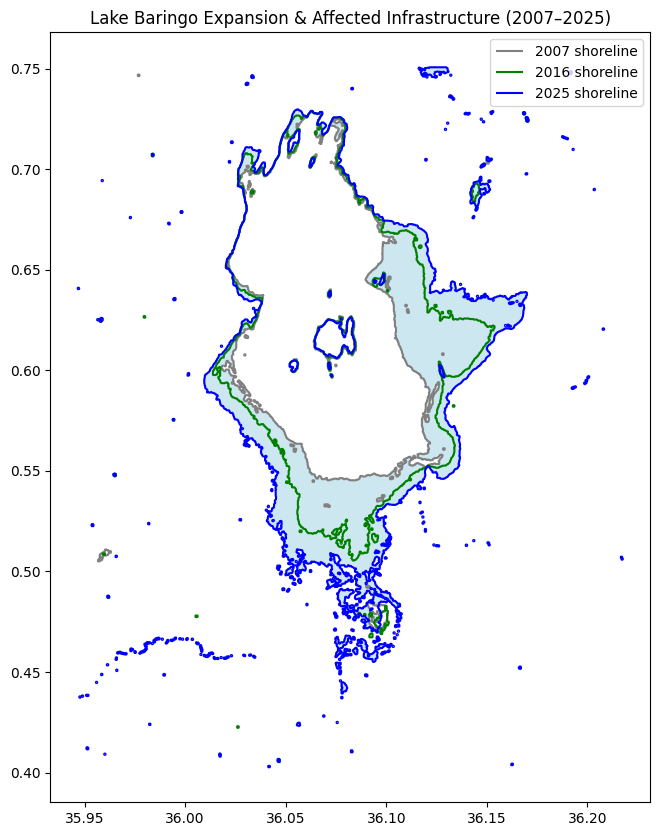

In [7]:
fig, ax = plt.subplots(figsize=(10, 10))
dissolved_2007.boundary.plot(ax=ax, color="gray", label="2007 shoreline")
dissolved_2016.boundary.plot(ax=ax, color="green", label="2016 shoreline")
dissolved_2025.boundary.plot(ax=ax, color="blue", label="2025 shoreline")
growth_area.plot(ax=ax, color="lightblue", alpha=0.6, label="Expansion area")
# submerged_buildings.plot(ax=ax, color="red", markersize=10, label="Submerged buildings")
# submerged_roads.plot(ax=ax, color="red", markersize=10, label="Submerged roads")
# submerged_facilities.plot(ax=ax, color="orange", markersize=20, label="Submerged Facilities")
plt.legend()
plt.title("Lake Baringo Expansion & Affected Infrastructure (2007–2025)")
plt.show()

In [8]:
# # --- Static comparison ---
# fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# for ax, (mndwi, vec, year) in zip(
#     axes,
#     [
#         (mndwi_2007, dissolved_2007, 2007),
#         (mndwi_2016, dissolved_2016, 2016),
#         (mndwi_2025, dissolved_2025, 2025),
#     ]
# ):
#     mndwi.plot(ax=ax, cmap="Blues", add_colorbar=False)
#     vec.boundary.plot(ax=ax, color="red", linewidth=1)
#     ax.set_title(f"Lake Baringo - {year}")
#     ax.axis("off")

# plt.tight_layout()
# plt.show()

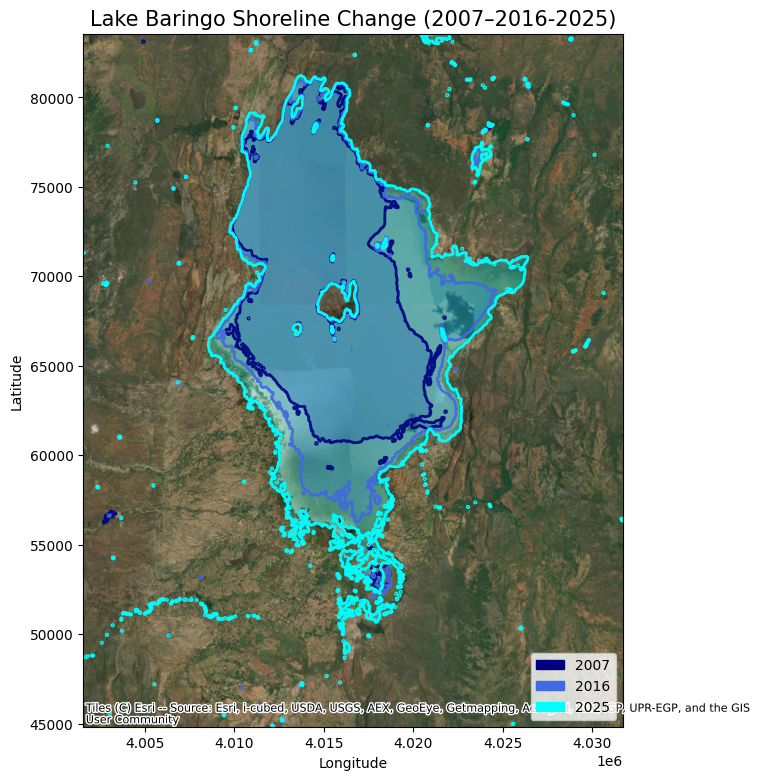

In [14]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import geopandas as gpd
import contextily as ctx
import matplotlib.patches as mpatches
import pandas as pd

# --- Ensure all data is in Web Mercator (for basemap) ---
shorelines = [
    (2007, dissolved_2007.to_crs(3857), 'navy'),
    (2016, dissolved_2016.to_crs(3857), 'royalblue'),
    (2025, dissolved_2025.to_crs(3857), 'aqua')
]

fig, ax = plt.subplots(figsize=(9, 9))

# Determine common extent (so the map doesn’t jump)
combined = gpd.GeoDataFrame(pd.concat([s[1] for s in shorelines], ignore_index=True))
ax.set_xlim(combined.total_bounds[0], combined.total_bounds[2])
ax.set_ylim(combined.total_bounds[1], combined.total_bounds[3])

# Add basemap once (under everything)
ctx.add_basemap(ax, source=ctx.providers.Esri.WorldImagery, zoom=12)

# Prepare legend
legend_patches = [mpatches.Patch(color=c, label=str(y)) for y, _, c in shorelines]

# Animation parameters
frames_per_transition = 25
total_frames = frames_per_transition * (len(shorelines) - 1)

def animate(frame):
    # Remove previous geometries (keep basemap)
    for coll in list(ax.collections):
        coll.remove()

    current_stage = frame // frames_per_transition
    alpha_progress = (frame % frames_per_transition) / frames_per_transition

    # Plot past shorelines solidly
    for j in range(current_stage + 1):
        year, gdf, color = shorelines[j]
        gdf.boundary.plot(ax=ax, color=color, linewidth=2, alpha=0.9)
        gdf.plot(ax=ax, color=color, alpha=0.25, edgecolor='none')

    # Smooth fade-in for the next shoreline
    if current_stage < len(shorelines) - 1:
        _, gdf_next, color_next = shorelines[current_stage + 1]
        gdf_next.boundary.plot(ax=ax, color=color_next, linewidth=2, alpha=alpha_progress)
        gdf_next.plot(ax=ax, color=color_next, alpha=alpha_progress * 0.25, edgecolor='none')

    ax.set_title("Lake Baringo Shoreline Change (2007–2016-2025)", fontsize=15)
    ax.legend(handles=legend_patches[:current_stage + 2], loc='lower right', frameon=True)
    ax.set_xlabel("Longitude")
    ax.set_ylabel("Latitude")

ani = animation.FuncAnimation(fig, animate, frames=total_frames, interval=1000, repeat=True)
ani.save("lake_baringo_shoreline_smooth.gif", writer="pillow", fps=15)
plt.show()
